In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from PIL import Image
import os
from runpy import run_path
from skimage import img_as_ubyte, io
from collections import OrderedDict
from natsort import natsorted
from glob import glob
import cv2
import argparse
import numpy as np
from skimage.metrics import structural_similarity as ssim
import json

def load_checkpoint(model, weights):
    checkpoint = torch.load(weights)
    try:
        model.load_state_dict(checkpoint["state_dict"])
    except:
        state_dict = checkpoint["state_dict"]
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v
        model.load_state_dict(new_state_dict)

def save_img(filepath, img):
    cv2.imwrite(filepath,cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

def rgb2gray(rgb):
  "used for ssim"
  return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

/home/sayyor/.local/share/virtualenvs/MPRNet-main-IRjlz4jv/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
import os
from natsort import natsorted
from glob import glob

In [3]:
# psnr_difference = {}

In [35]:
model_name = '_noFreezing_100e'
type = 'Deblurring'

# noisy_lego_dir = '/home/sayyor/Desktop/BDMA_Studies/BDRP/CS-BDRP-nerf/running_outputs/KiloNeRF_16epochs_400/'
orig_lego_dir = '/home/sayyor/Desktop/BDMA_Studies/BDRP/CS-BDRP-nerf/running_outputs/lego_orig_all/'
tiny_lego_dir = '/home/sayyor/Desktop/BDMA_Studies/BDRP/CS-BDRP-nerf/running_outputs/tinyNerf_test_400/'
# noisy_nds_dir = '/home/sayyor/Desktop/BDMA_Studies/BDRP/CS-BDRP-nerf/dataset/noisy-01/'
# orig_nds_dir = '/home/sayyor/Desktop/BDMA_Studies/BDRP/CS-BDRP-nerf/dataset/test-01/'
model_dir = 'results/MPRNet_'+type+'/model_best'+model_name+'.pth'
output = 'mprnet_'+type+model_name+'/'

def calculate_psnr(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

In [36]:
command = f"python {type}/test.py --input_dir {tiny_lego_dir} --result_dir {output} --weights {model_dir}"
os.system(command)

===>Testing using weights:  results/MPRNet_Deblurring/model_best_noFreezing_100e.pth
rgb_dir_test /home/sayyor/Desktop/BDMA_Studies/BDRP/CS-BDRP-nerf/running_outputs/tinyNerf_test_400/


100%|██████████| 29/29 [00:49<00:00,  1.72s/it]


0

In [58]:
noisy_path = tiny_lego_dir
orig_path = orig_lego_dir
type = 'Deraining'
model_names = ['_lastLayer_100e/', '_best_last_SAM_100e/']
psnrs_difference = {}

for model_name in model_names:
    output = 'mprnet_'+type+model_name

    noisy = natsorted(glob(os.path.join(noisy_path, '*.png')))
    orig = natsorted(glob(os.path.join(orig_path, '*.png')))

    after = natsorted(glob(os.path.join(output, '*.png')))
    after_fs = [f.split("/")[-1] for f in after]

    psnrs_before = []
    psnrs_after = []

    for file_ in after_fs:
        noisy_f = noisy_path+file_
        orig_f = orig_path+file_
        after_f = output+file_

        noisy_i = io.imread(noisy_path+file_)
        orig_i = io.imread(orig_path+file_)
        after_i = io.imread(output+file_)

        psnr_b4 = calculate_psnr(cv2.imread(orig_f), cv2.imread(noisy_f))
        psnr_after = calculate_psnr(cv2.imread(orig_f), cv2.imread(after_f))
        psnrs_before.append(psnr_b4)
        psnrs_after.append(psnr_after)
    
    psnrs_difference[model_name] = np.array(psnrs_after) - np.array(psnrs_before)

In [59]:
psnrs_difference

{'_lastLayer_100e/': array([0.24308709, 0.28540455, 0.30588154, 0.35144967, 0.3272869 ,
        0.36014855, 0.31249253, 0.31439863, 0.29088245, 0.28910197,
        0.27577015, 0.28275999, 0.23483302, 0.25115047, 0.24565299,
        0.27539694, 0.25241826, 0.25510927, 0.25568879, 0.18600936,
        0.15598016, 0.14771469, 0.17710164, 0.23100735, 0.2538351 ,
        0.258146  , 0.26458728, 0.26692575, 0.26095013]),
 '_best_last_SAM_100e/': array([0.26496669, 0.30025444, 0.32012041, 0.3721584 , 0.33546836,
        0.37545738, 0.34256305, 0.33964011, 0.3059124 , 0.31056036,
        0.29974922, 0.30544874, 0.25043573, 0.26278784, 0.26766109,
        0.30378856, 0.26975989, 0.27064178, 0.27959668, 0.19214738,
        0.16412209, 0.15537315, 0.17678541, 0.23044128, 0.23950163,
        0.24851997, 0.25799116, 0.25940423, 0.26301372])}

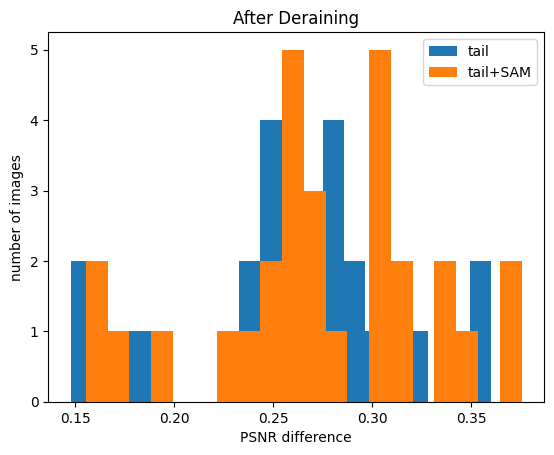

In [61]:
labels = ['tail', 'tail+SAM']

for i, model_name in enumerate(psnrs_difference):
    label = labels[i]
    plt.hist(psnrs_difference[model_name], bins=20, label=label)

# Add titles and labels
plt.title(f"After {type}")
plt.xlabel('PSNR difference')
plt.ylabel("number of images")
plt.legend()
plt.savefig(f"plots/psnrHist_{type}_allModels.png")

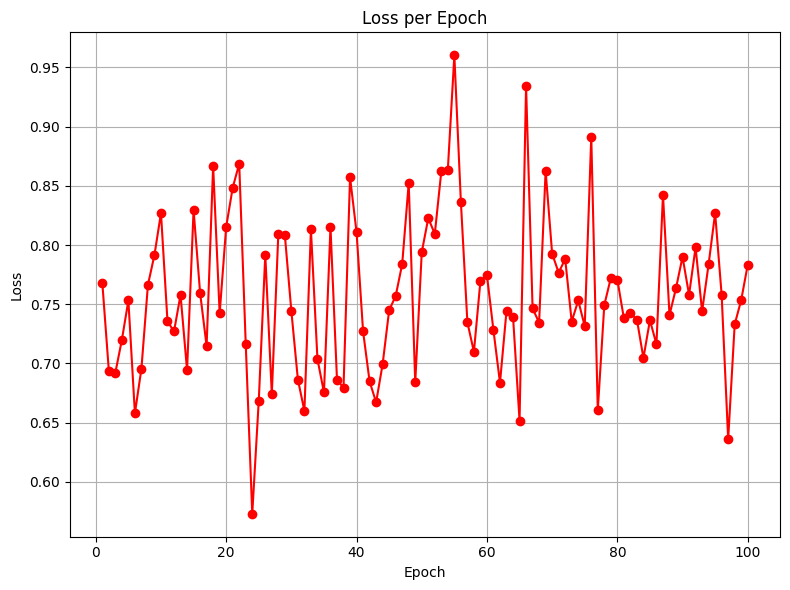

In [8]:
### Plotting the change in loss and PSNR

epochs_dir = 'results/MPRNet_'+type+'/epochs_'+model_name+'.json'

# Extracted data
epochs = range(1, 101)
with open(epochs_dir, 'r') as file:
    losses = json.load(file)

# Plotting
plt.figure(figsize=(8, 6))

# Plot for Loss
plt.plot(epochs, losses, marker='o', color='r', label='Loss per Epoch')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.savefig(f"plots/lossOverEpoch_{type}{model_name}.png")
plt.show()

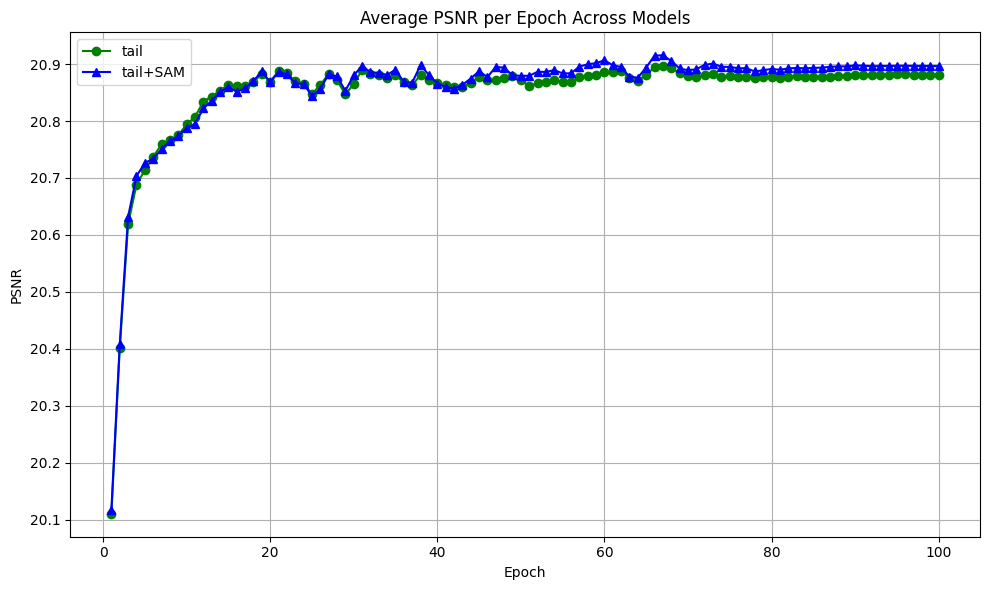

In [63]:
### Plotting the change in loss and PSNR
model_names = ['_lastLayer_100e', '_last_SAM_100e']

colors = ['g', 'b', 'r']  # Different colors for each model
markers = ['o', '^', 's']  # Different markers for each model
labels = ['tail', 'tail+SAM', 'noFreezing']

# Plotting
plt.figure(figsize=(10, 6))

# Loop through each model
for model_name, color, marker, label in zip(model_names, colors, markers, labels):
    epochs_dir = f'results/MPRNet_{type}/psnrs_{model_name}.json'
    
    # Extract data
    with open(epochs_dir, 'r') as file:
        losses = json.load(file)
    
    epochs = range(1, len(losses) + 1)
    
    # Plot for each model
    plt.plot(epochs, losses, marker=marker, color=color, label=label)

plt.title('Average PSNR per Epoch Across Models')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(f"plots/psnrOverEpoch_{type}_AllModels.png")
plt.show()

In [20]:
print([np.mean(psnrs_before), np.mean(psnrs_after)])
# psnr_difference[f'{type}{model_name}'] = (np.mean(psnrs_after) - np.mean(psnrs_before))

[25.741675186168504, 25.975994846393384]


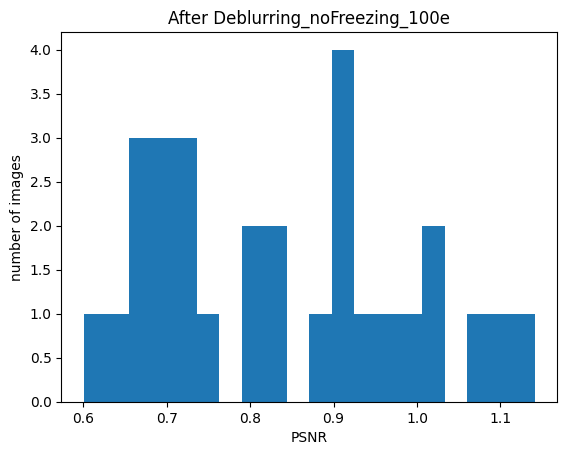

In [39]:
plt.hist(np.array(psnrs_after)-np.array(psnrs_before), bins=20)

# Add titles and labels
plt.title(f"After {type}{model_name}")
plt.xlabel('PSNR')
plt.ylabel("number of images")
plt.savefig(f"plots/psnrHist_{type}{model_name}.png")

In [5]:
task = 'Deblurring'

# Load corresponding model architecture and weights
load_file = run_path(os.path.join(task, "MPRNet.py"))
model = load_file['MPRNet']()
model.cuda()

load_checkpoint(model, model_dir)
model.eval()

img_multiple_of = 8

for file_ in noisy:
    img = Image.open(file_).convert('RGB')
    input_ = TF.to_tensor(img).unsqueeze(0).cuda()

    # Pad the input if not_multiple_of 8
    h,w = input_.shape[2], input_.shape[3]
    H,W = ((h+img_multiple_of)//img_multiple_of)*img_multiple_of, ((w+img_multiple_of)//img_multiple_of)*img_multiple_of
    padh = H-h if h%img_multiple_of!=0 else 0
    padw = W-w if w%img_multiple_of!=0 else 0
    input_ = F.pad(input_, (0,padw,0,padh), 'reflect')

    with torch.no_grad():
        restored = model(input_)
    restored = restored[0]
    restored = torch.clamp(restored, 0, 1)

    # Unpad the output
    restored = restored[:,:,:h,:w]

    restored = restored.permute(0, 2, 3, 1).cpu().detach().numpy()
    restored = img_as_ubyte(restored[0])

    f = file_.split("/")[-1]
    save_img((os.path.join(output, f)), restored)

In [38]:
after = natsorted(glob(os.path.join(output, '*.png')))
after_fs = [f.split("/")[-1] for f in after]

psnrs_before = []
psnrs_after = []
ssims_before = []
ssims_after = []

for file_ in after_fs:
    noisy_i = io.imread(noisy_lego_dir+file_)
    orig_i = io.imread(orig_lego_dir+file_)
    after_i = io.imread(output+file_)
    
    noisy_i = noisy_i.astype(np.float32)/255.0
    orig_i = orig_i.astype(np.float32)/255.0
    after_i = after_i.astype(np.float32)/255.0

    psnr_b4 = cv2.PSNR(orig_i, noisy_i)
    psnr_after = cv2.PSNR(orig_i, after_i)
    psnrs_before.append(psnr_b4)
    psnrs_after.append(psnr_after)

    noisy_i = rgb2gray(noisy_i)
    orig_i = rgb2gray(orig_i)
    after_i = rgb2gray(after_i)
    ssim_b4 = ssim(orig_i, noisy_i,data_range=noisy_i.max() - noisy_i.min())
    ssim_after = ssim(orig_i, after_i,data_range=after_i.max() - after_i.min())
    ssims_before.append(ssim_b4)
    ssims_after.append(ssim_after)

In [41]:
np.mean(psnrs_before), np.mean(psnrs_after), np.mean(ssims_before), np.mean(ssims_after)

(75.64687812466957, 73.64321981397201, 0.9247445600215882, 0.9162253068523879)

In [64]:
len(psnrs_after)

200

Text(0, 0.5, 'frequency')

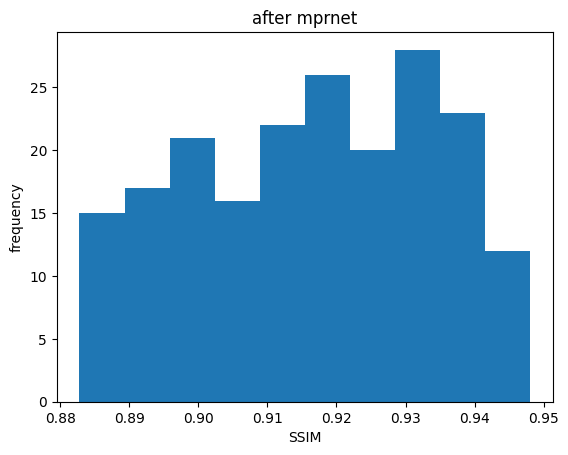

In [77]:
plt.hist(ssims_after, bins=10)

# Add titles and labels
plt.title("after mprnet")
plt.xlabel('SSIM')
plt.ylabel("frequency")

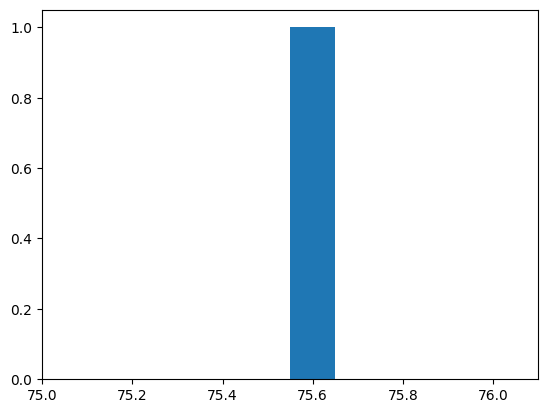

In [62]:
plt.hist(psnr_after)
plt.show()

In [8]:
noisy_lego_dir = '/home/sayyor/Desktop/BDMA_Studies/BDRP/CS-BDRP-nerf/running_outputs/KiloNeRF_16epochs_400/'
orig_lego_dir = '/home/sayyor/Desktop/BDMA_Studies/BDRP/CS-BDRP-nerf/running_outputs/lego_orig_all/'

model_dir = 'Deblurring/model_best.pth'
output = 'first_output/'

In [19]:
list(range(0,5*5,5))

[0, 5, 10, 15, 20]

In [80]:
import matplotlib.pyplot as plt
from PIL import Image

In [81]:
# Define a function to calculate the residual image by subtracting the reconstructed image from the original
def calculate_residual(original_path, reconstructed_path):
    # Read the original and reconstructed images
    original = cv2.imread(original_path, cv2.IMREAD_UNCHANGED)
    reconstructed = cv2.imread(reconstructed_path, cv2.IMREAD_UNCHANGED)
    
    # Convert images to float for accurate subtraction
    original_float = original.astype(np.float32)
    reconstructed_float = reconstructed.astype(np.float32)
    
    # Calculate the residual
    residual = original_float - reconstructed_float
    
    # Clip values to the range [0, 255] and convert to uint8
    residual_clipped = np.clip(residual, 0, 255).astype(np.uint8)
    
    return residual_clipped

def plot_residual_between2(original_dir, noisy1_dir, title, n_images=3):
    # Paths to the original images
    noisy_lego_dir = noisy1_dir

    n_images = 3
    image_range = range(0,5*n_images,n_images)
    original_paths = [orig_lego_dir+f'{i}.png' for i in image_range]
    noisy_paths = [noisy_lego_dir+f'{i}.png' for i in image_range]

    # Calculate the residual for each pair of original and reconstructed images
    residual_images = [calculate_residual(original_paths[i], noisy_paths[i]) for i in range(n_images)]

    # Save the residual images and prepare their file paths for output
    residual_noisy_paths = []
    for i, residual in enumerate(residual_images):
        path = f'residual_noisy/{i}.png'
        cv2.imwrite(path, residual)
        residual_noisy_paths.append(path)

    # Plot the residual images
    fig, axes = plt.subplots(1, n_images, figsize=(10, 4))
    fig.suptitle(title, fontsize=13)
    for i, ax in enumerate(axes):
        ax.imshow(residual_images[i], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def plot_images(noisy1_dir, title, n_images=3):
    # Paths to the original images
    noisy_lego_dir = noisy1_dir

    n_images = 3
    image_range = range(0, 5 * n_images, n_images)
    noisy_paths = [noisy_lego_dir + f'{i}.png' for i in image_range]

    # Plot the images
    fig, axes = plt.subplots(1, n_images, figsize=(10, 4))
    fig.suptitle(title, fontsize=13)
    for i, ax in enumerate(axes):
        img = Image.open(noisy_paths[i])
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [58]:
nds_output = '/home/sayyor/Desktop/BDMA_Studies/BDRP/CS-BDRP-nerf/running_outputs/original_nds/'

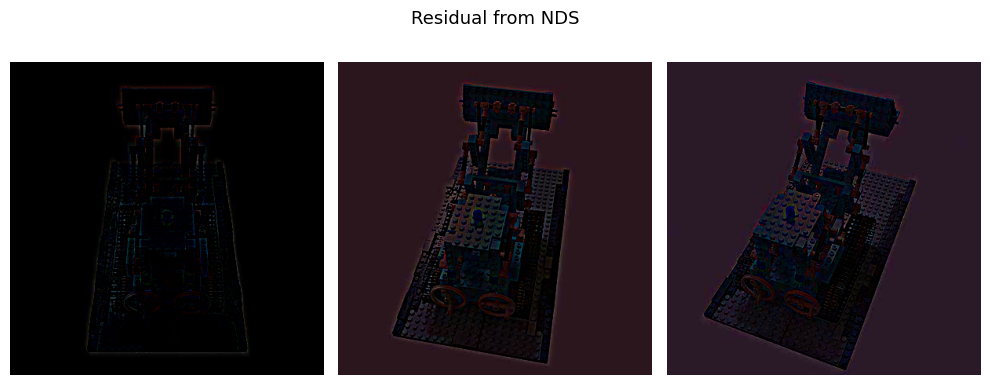

In [59]:
plot_residual_between2(orig_lego_dir, nds_output, 'Residual from NDS')

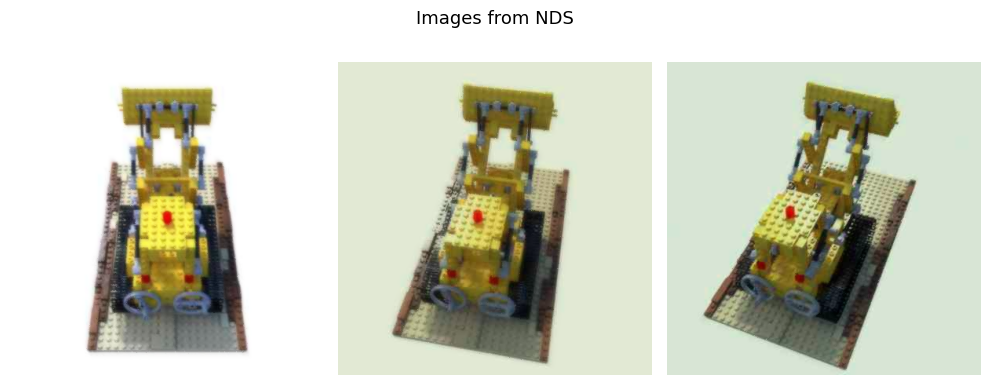

In [82]:
plot_images(nds_output, 'Images from NDS', n_images=3)